## Tranfer Learning Model

## Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Data Preprocessing

In [3]:
data_dir = 'Data'      
img_size = (128, 128)   

images = []
labels = []

classes = sorted(os.listdir(data_dir))
print("Detected classes:", classes)

for label, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
        
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            # Load and resize
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_file}: {e}")

X = np.array(images, dtype="float32") / 255.0   # normalize pixels
y = np.array(labels)

print(f"Total images: {len(X)}")
print(f"Image shape: {X.shape}")

y_cat = to_categorical(y, num_classes=len(classes))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Detected classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '7', '8', '9', 'files.txt']
Error loading .ipynb_checkpoints: [Errno 13] Permission denied: 'Data\\0\\.ipynb_checkpoints'
Error loading .ipynb_checkpoints: [Errno 13] Permission denied: 'Data\\16\\.ipynb_checkpoints'
Error loading .ipynb_checkpoints: [Errno 13] Permission denied: 'Data\\2\\.ipynb_checkpoints'
Total images: 1360
Image shape: (1360, 128, 128, 3)
Training samples: 1088
Testing samples: 272


## Model Training

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


num_classes = y_train.shape[1]  # e.g., 18

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

vgg_model = Model(inputs=base_model.input, outputs=predictions)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

# --- Compile model ---
vgg_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg_model.summary()

# --- Stage 1: Train top layers only ---
history_top = vgg_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test)
)


for layer in base_model.layers[-4:]:
    layer.trainable = True

vgg_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = vgg_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,  
    validation_data=(X_test, y_test)
)




 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 19,048,530 (72.66 MB)

 Trainable params: 4,332,306 (16.53 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

Epoch 1/10


C:\Users\kgadg\anaconda3\envs\Deep_Learning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 732ms/step - accuracy: 0.1133 - loss: 3.6230 - val_accuracy: 0.2353 - val_loss: 2.4791
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 724ms/step - accuracy: 0.2941 - loss: 2.4584 - val_accuracy: 0.4779 - val_loss: 1.9809
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 726ms/step - accuracy: 0.4540 - loss: 1.7574 - val_accuracy: 0.6250 - val_loss: 1.5857
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 726ms/step - accuracy: 0.5692 - loss: 1.5014 - val_accuracy: 0.6985 - val_loss: 1.3243
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 717ms/step - accuracy: 0.5865 - loss: 1.3892 - val_accuracy: 0.7169 - val_loss: 1.1501
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 808ms/step - accuracy: 0.6221 - loss: 1.2051 - val_accuracy: 0.7353 - val_loss: 1.0070
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 737ms/step - accuracy: 0.6645 - loss: 1.0873 - val_accuracy: 0.7757 - val_loss: 0.8797
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 738ms/step - accuracy: 0.6774 - loss: 1.0050 - val_accuracy: 0.761

## Classification Report

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 580ms/step - accuracy: 0.8831 - loss: 0.3822

VGG16 Final Test Accuracy: 0.8897
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 570ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       0.88      0.94      0.91        16
          10       1.00      1.00      1.00        16
          11       0.93      0.88      0.90        16
          12       0.93      0.88      0.90        16
          13       0.82      0.56      0.67        16
          14       0.79      0.94      0.86        16
          15       0.93      0.88      0.90        16
          16       0.88      0.94      0.91        16
           2       0.93      0.88      0.90        16
           3       1.00      0.88      0.93        16
           4       1.00      0.94      0.97        16
           5       1.00      0.88      0.93        16
           6       0.79      0.94      0.86        16
           7     

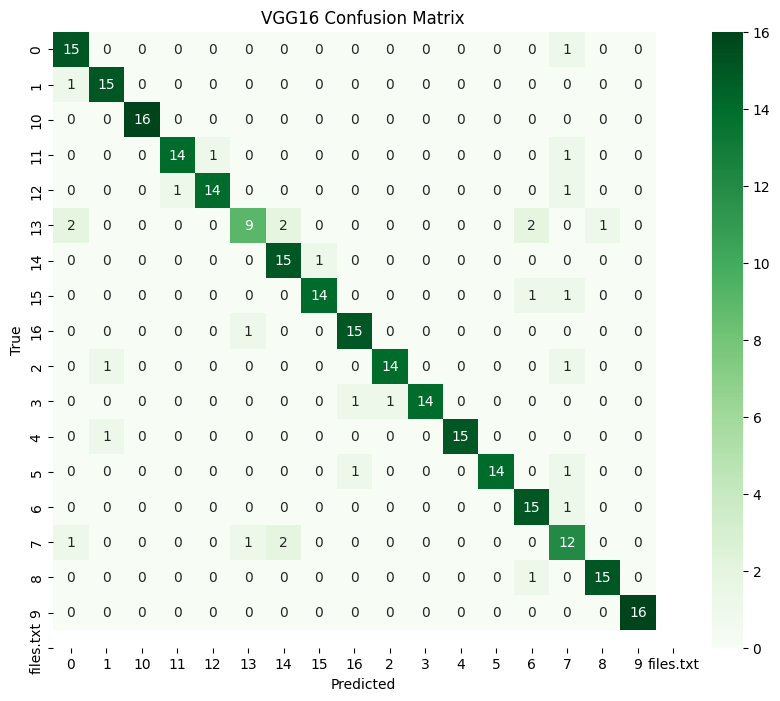

In [11]:
test_loss, test_acc = vgg_model.evaluate(X_test, y_test)
print(f"\nVGG16 Final Test Accuracy: {test_acc:.4f}")

y_pred = vgg_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=classes[:len(np.unique(y_true))]))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=classes, yticklabels=classes)
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

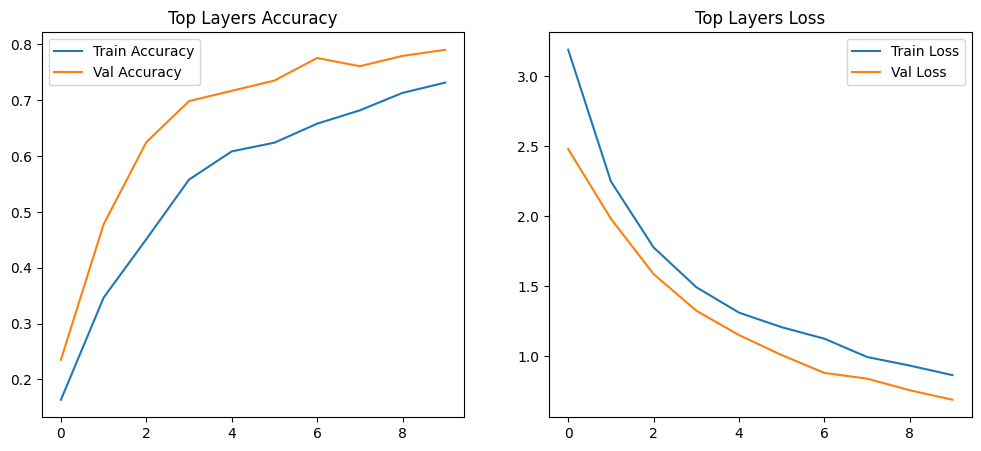

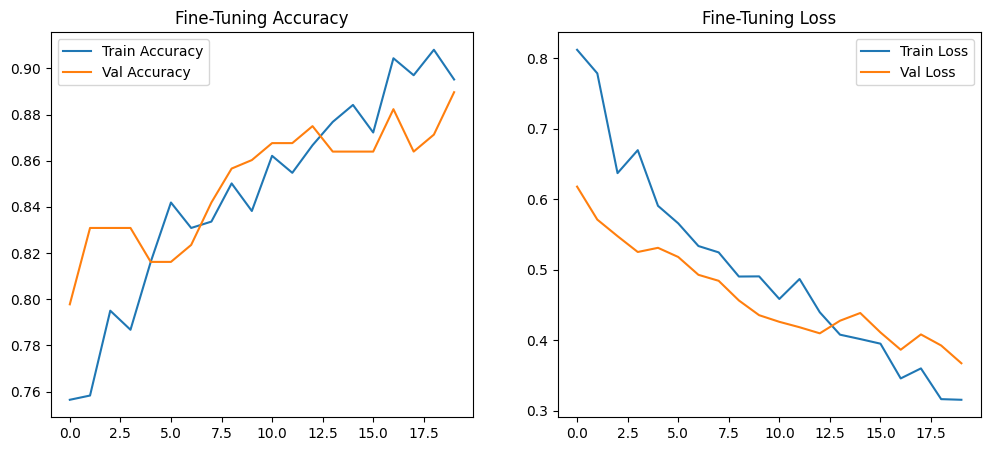

In [12]:
def plot_history(history, title):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

plot_history(history_top, "Top Layers")
plot_history(history_finetune, "Fine-Tuning")

## Model Saving

In [18]:
vgg_model.save("flowers17_model.h5")


In [19]:
import os
print(os.path.exists("flowers17_model.h5"))


True


## Testing

Model class order alignment:
 0 → daffodil
 1 → snowdrop
 2 → daisy
 3 → coltsfoot
 4 → dandelion
 5 → cowslip
 6 → buttercup
 7 → windflower
 8 → pansy
 9 → lily_valley
10 → bluebell
11 → crocus
12 → iris
13 → tigerlily
14 → tulip
15 → fritillary
16 → sunflower
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


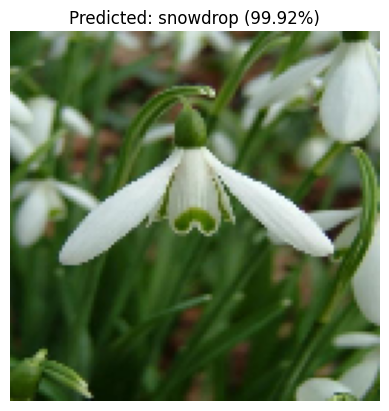

Custom CNN predicts: snowdrop (99.92%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


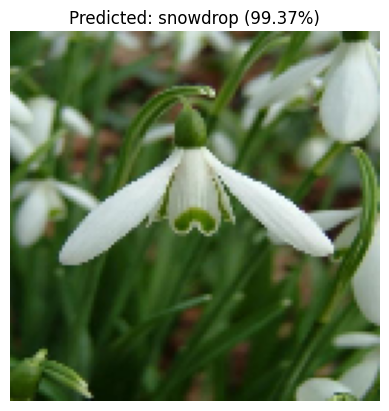

VGG16 predicts: snowdrop (99.37%)


In [40]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(model, img_path, class_names, target_size=(128,128)):
    """
    model: trained Keras model (cnn_model or vgg_model)
    img_path: path to the image file
    class_names: list of class labels
    target_size: input size expected by the model
    """
    # Load and preprocess image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    # Predict
    pred = model.predict(img_array)
    class_index = np.argmax(pred, axis=1)[0]
    confidence = np.max(pred)
    class_label = class_names[class_index]

    # Show image with prediction
    plt.imshow(img)
    plt.title(f"Predicted: {class_label} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

    return class_label, confidence


flower_names = [
    "daffodil", "snowdrop", "lily_valley", "bluebell", "crocus", "iris", "tigerlily",
    "tulip", "fritillary", "sunflower", "daisy", "coltsfoot", "dandelion",
    "cowslip", "buttercup", "windflower", "pansy"
]

data_dir = "Data"
classes_lex = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
aligned_flower_names = [flower_names[int(folder)] for folder in classes_lex]

print("Model class order alignment:")
for i, name in enumerate(aligned_flower_names):
    print(f"{i:2d} → {name}")


img_path = "Data/1/image_0082.jpg"  

# Predict using your trained models
predicted_class_cnn, conf_cnn = predict_image(cnn_model, img_path, aligned_flower_names)
print(f"Custom CNN predicts: {predicted_class_cnn} ({conf_cnn*100:.2f}%)")

predicted_class_vgg, conf_vgg = predict_image(vgg_model, img_path, aligned_flower_names)
print(f"VGG16 predicts: {predicted_class_vgg} ({conf_vgg*100:.2f}%)")
